In [1]:
misc_inputs = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/misc_inputs.csv'
dss = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/ieee37.dss'
load_solar = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/load_solar_data.csv'
breakpoints = '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/breakpoints.csv'


misc_inputs_bat = '/home/toanngo/Documents/GitHub/ceds-cigar/pycigar/data/ieee37busdata_battery/misc_inputs.csv'
#load_solar_bat = '/home/toanngo/Documents/GitHub/ceds-cigar/pycigar/data/ieee37busdata_battery/load_solar_data.csv'
load_solar_bat = '/home/toanngo/Documents/GitHub/ceds-cigar/pycigar/data/ieee37busdata_battery/load_solar_data_new.csv'

bat = '/home/toanngo/Documents/GitHub/ceds-cigar/pycigar/data/ieee37busdata_battery/battery_inputs.txt'

In [2]:
import pandas as pd

solar_load_bat = pd.read_csv(load_solar_bat)
solar_load = pd.read_csv(load_solar)

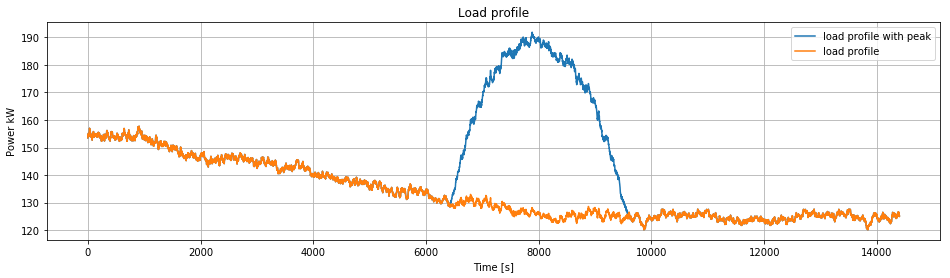

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(solar_load_bat['S701a']),label="load profile with peak")
plt.plot(np.asarray(solar_load['S701a']),label="load profile")
# plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],label="substation reactive power")
# plt.plot((np.asarray(Logger.log_dict['network']['substation_power'])[:,0]**2 + np.asarray(Logger.log_dict['network']['substation_power'])[:,1]**2)**0.5,label="substation apparent power")
plt.grid()
plt.title('Load profile')
plt.xlabel('Time [s]')
plt.ylabel('Power kW')
plt.legend()


In [3]:
from pycigar.utils.input_parser import input_parser
import numpy as np
from pycigar.utils.registry import register_devcon
import tensorflow as tf
from ray.rllib.models.catalog import ModelCatalog
from gym.spaces import Tuple, Discrete, Box

misc_inputs = misc_inputs_bat
dss = dss
load_solar = load_solar_bat
breakpoints = breakpoints
bat = bat

start = 100
hack = 0.4
sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, vectorized_mode=True, percentage_hack=hack)

# sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, vectorized_mode=True, percentage_hack=hack, battery_path=bat)
# for node in sim_params['scenario_config']['nodes']:
#     for device in node['devices']:
#         if device['device'] == 'battery_storage_device':
#             device['device'] = 'battery_storage_device_vvc'

sim_params['scenario_config']['start_end_time'] = [start, start + 750]

del sim_params['attack_randomization']
for node in sim_params['scenario_config']['nodes']:
    node['devices'][0]['adversary_controller'] =  'adaptive_unbalanced_fixed_controller'
start = 3601
duration = 14400 - start

#start = 3601
#duration = 200

from pycigar.utils.registry import register_devcon
from pycigar.devices.battery_storage_device_VVC import BatteryStorageDeviceVVC
register_devcon('battery_storage_device_vvc', BatteryStorageDeviceVVC)

sim_params['vectorized_mode'] = True
sim_params['scenario_config']['start_end_time'] = [start, start + duration]
sim_params['scenario_config']['multi_config'] = False
sim_params['scenario_config']['custom_configs']['slack_bus_voltage'] = 1.02
#sim_params['scenario_config']['custom_configs']['solar_scaling_factor'] = 1
sim_params['simulation_config']['custom_configs']['solution_control_mode'] = 2

from pycigar.envs import CentralControlPhaseSpecificPVInverterEnv
env = CentralControlPhaseSpecificPVInverterEnv(sim_params=sim_params)
env.reset()
done = False
while not done:
    _, r, done, _ = env.step([10, 10, 10])
    print(done, end = " ")

Instructions for updating:
non-resource variables are not supported in the long term
False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

In [5]:
from pycigar.utils.logging import logger
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

# BASELINE

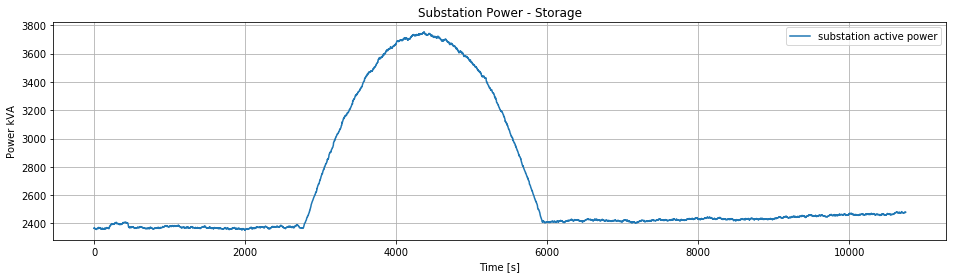

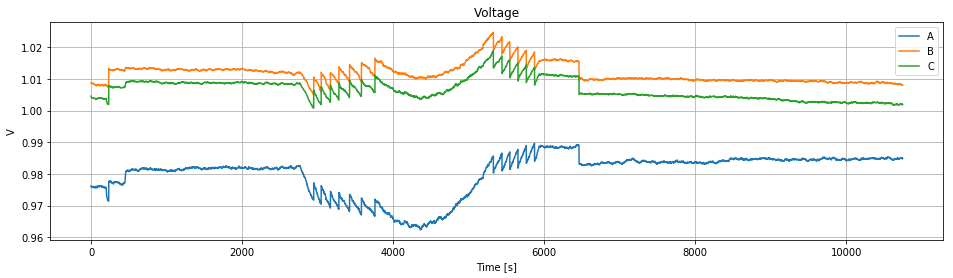

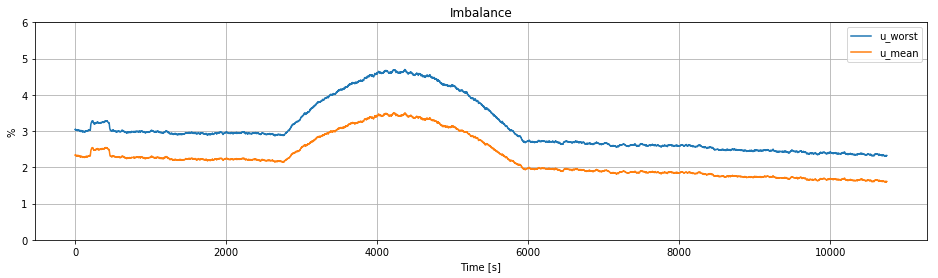

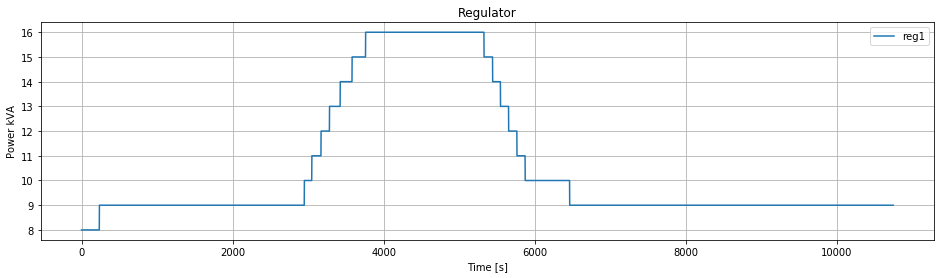

In [6]:
import matplotlib.pyplot as plt
plt.switch_backend('Tkagg')
import numpy as np
%matplotlib inline

#substation power
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
#plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="target substation active power")
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#voltage
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['s701a']['voltage'], label='A')
plt.plot(log_dict['s701b']['voltage'], label='B')
plt.plot(log_dict['s701c']['voltage'], label='C')
plt.title('Voltage')
plt.xlabel('Time [s]')
plt.ylabel('V')
plt.grid()
plt.legend()
plt.show()

#imbalance
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(log_dict['u_metrics']['u_worst'])*100, label='u_worst')
plt.plot(np.array(log_dict['u_metrics']['u_mean'])*100, label='u_mean')
plt.ylim([0, 6])
plt.title('Imbalance')
plt.xlabel('Time [s]')
plt.ylabel('%')
plt.grid()
plt.legend()
plt.show()

#regulator
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['reg1']['tap_number'], label='reg1')
plt.title('Regulator')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#q_out
# fig1 = plt.figure(figsize = [16, 4])
# for battery in [i for i in log_dict.keys() if 'bsd' in i]:
#     plt.plot(log_dict[battery]['q_out'], label=battery)
# plt.title('Reactive output')
# plt.xlabel('Time [s]')
# plt.ylabel('Re.Power kVAr')
# plt.grid()
# plt.legend()
# plt.show()

# WITH Q

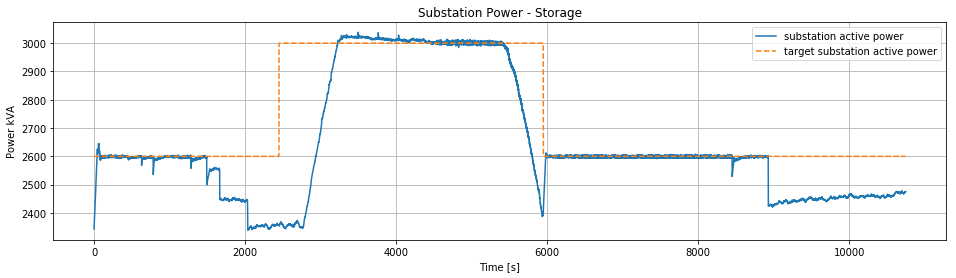

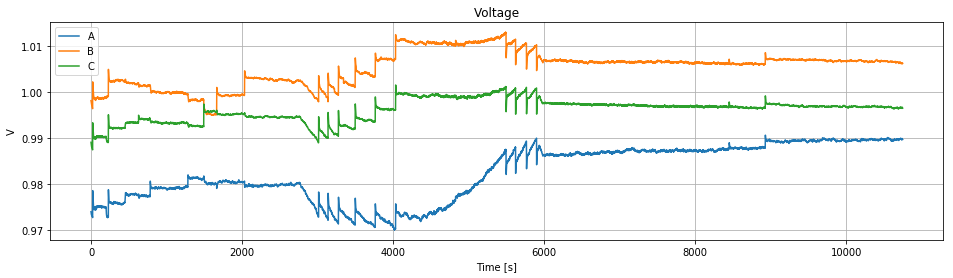

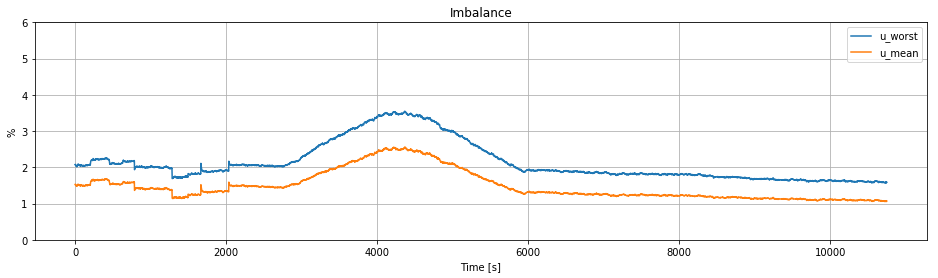

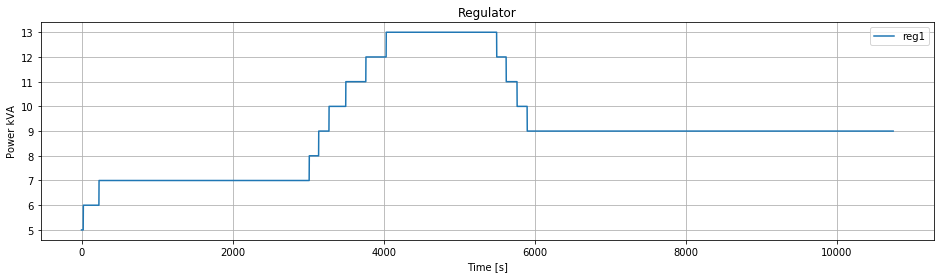

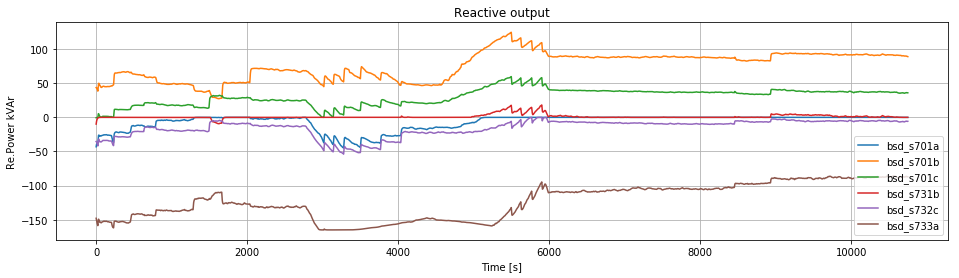

In [6]:
import matplotlib.pyplot as plt
plt.switch_backend('Tkagg')
import numpy as np
%matplotlib inline

#substation power
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="target substation active power")
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#voltage
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['s701a']['voltage'], label='A')
plt.plot(log_dict['s701b']['voltage'], label='B')
plt.plot(log_dict['s701c']['voltage'], label='C')
plt.title('Voltage')
plt.xlabel('Time [s]')
plt.ylabel('V')
plt.grid()
plt.legend()
plt.show()

#imbalance
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(log_dict['u_metrics']['u_worst'])*100, label='u_worst')
plt.plot(np.array(log_dict['u_metrics']['u_mean'])*100, label='u_mean')
plt.ylim([0, 6])
plt.title('Imbalance')
plt.xlabel('Time [s]')
plt.ylabel('%')
plt.grid()
plt.legend()
plt.show()

#regulator
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['reg1']['tap_number'], label='reg1')
plt.title('Regulator')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#q_out
fig1 = plt.figure(figsize = [16, 4])
for battery in [i for i in log_dict.keys() if 'bsd' in i]:
    plt.plot(log_dict[battery]['q_out'], label=battery)
plt.title('Reactive output')
plt.xlabel('Time [s]')
plt.ylabel('Re.Power kVAr')
plt.grid()
plt.legend()
plt.show()

# WITHOUT Q

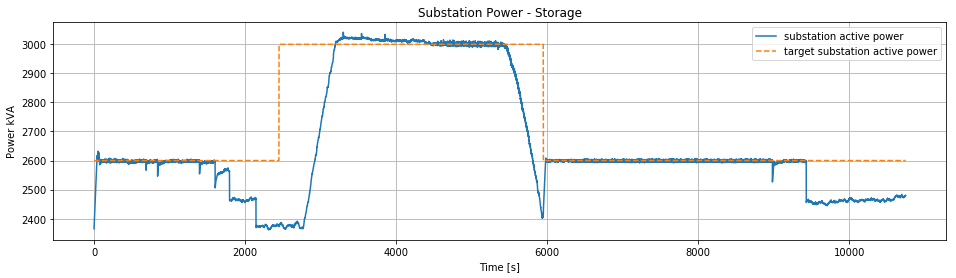

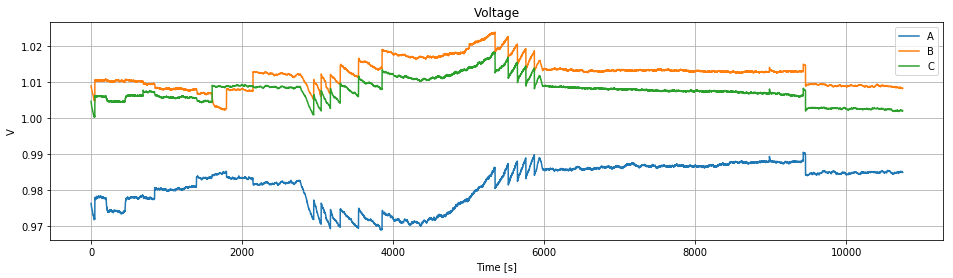

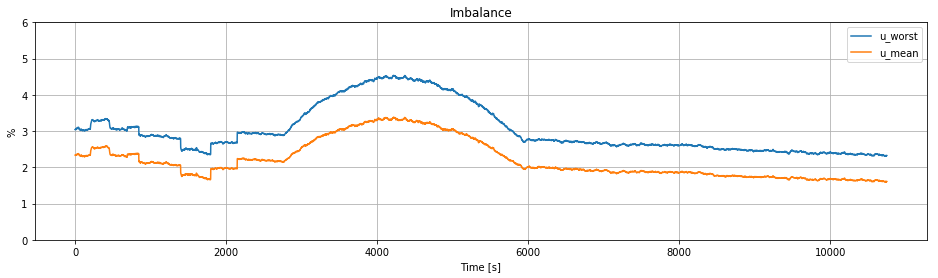

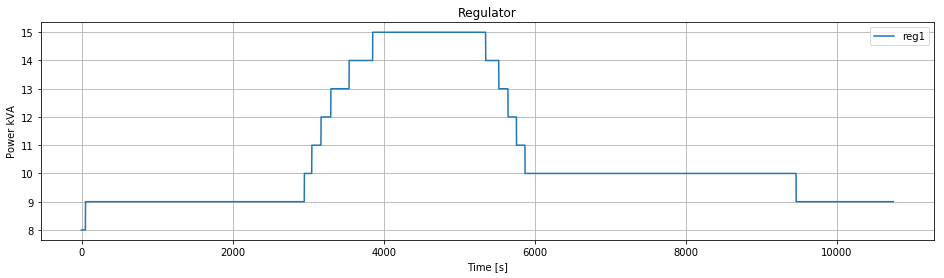

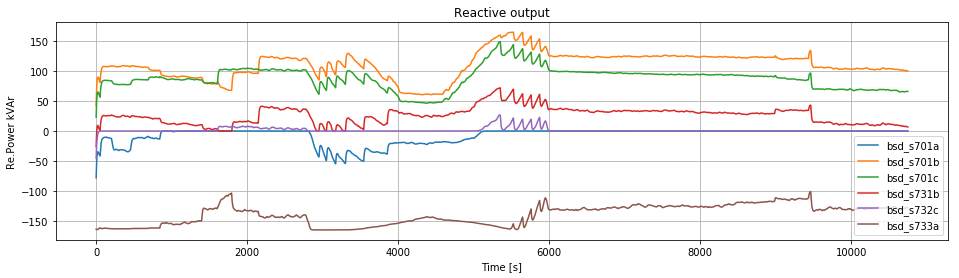

In [6]:
import matplotlib.pyplot as plt
plt.switch_backend('Tkagg')
import numpy as np
%matplotlib inline

#substation power
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="target substation active power")
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#voltage
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['s701a']['voltage'], label='A')
plt.plot(log_dict['s701b']['voltage'], label='B')
plt.plot(log_dict['s701c']['voltage'], label='C')
plt.title('Voltage')
plt.xlabel('Time [s]')
plt.ylabel('V')
plt.grid()
plt.legend()
plt.show()

#imbalance
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(log_dict['u_metrics']['u_worst'])*100, label='u_worst')
plt.plot(np.array(log_dict['u_metrics']['u_mean'])*100, label='u_mean')
plt.ylim([0, 6])
plt.title('Imbalance')
plt.xlabel('Time [s]')
plt.ylabel('%')
plt.grid()
plt.legend()
plt.show()

#regulator
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['reg1']['tap_number'], label='reg1')
plt.title('Regulator')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.grid()
plt.legend()
plt.show()

#q_out
fig1 = plt.figure(figsize = [16, 4])
for battery in [i for i in log_dict.keys() if 'bsd' in i]:
    plt.plot(log_dict[battery]['q_out'], label=battery)
plt.title('Reactive output')
plt.xlabel('Time [s]')
plt.ylabel('Re.Power kVAr')
plt.grid()
plt.legend()
plt.show()

In [6]:
import matplotlib.pyplot as plt
plt.switch_backend('Tkagg')
import numpy as np
%matplotlib inline

fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="substation active power")
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
# plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],label="substation reactive power")
# plt.plot((np.asarray(Logger.log_dict['network']['substation_power'])[:,0]**2 + np.asarray(Logger.log_dict['network']['substation_power'])[:,1]**2)**0.5,label="substation apparent power")
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['psc_cent_701']['measured_active_power_lpf'],label="p set")
plt.plot(np.asarray(log_dict['psc_cent_701']['measured_active_power_lpf']) - 3*np.asarray(log_dict['psc_cent_701']['p_set']),label="p set")
plt.plot(log_dict['psc_cent_730']['measured_active_power_lpf'],label="p set")
plt.plot(np.asarray(log_dict['psc_cent_730']['measured_active_power_lpf']) - 3*np.asarray(log_dict['psc_cent_730']['p_set']),label="p set")
plt.title('Setpoints')
plt.xlabel('Time [s]')
plt.ylabel('Power [kVA]')
plt.legend()

plt.show()

KeyError: 'psc_cent_701'

<Figure size 1152x288 with 0 Axes>

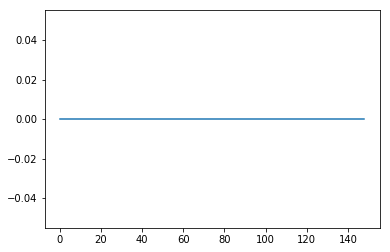

In [8]:
plt.plot(log_dict['bsd_s701a']['bat_cycle'])

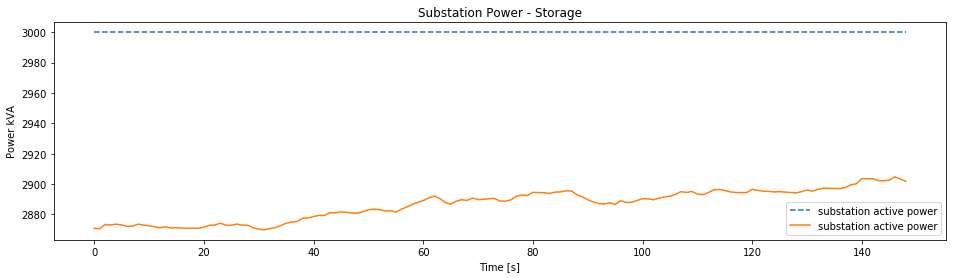

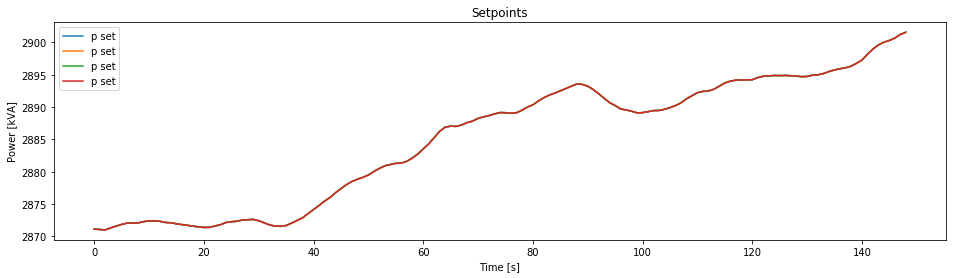

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="substation active power")
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
# plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],label="substation reactive power")
# plt.plot((np.asarray(Logger.log_dict['network']['substation_power'])[:,0]**2 + np.asarray(Logger.log_dict['network']['substation_power'])[:,1]**2)**0.5,label="substation apparent power")
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.legend()

fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['psc_cent_701']['measured_active_power_lpf'],label="p set")
plt.plot(np.asarray(log_dict['psc_cent_701']['measured_active_power_lpf']) - 3*np.asarray(log_dict['psc_cent_701']['p_set']),label="p set")
plt.plot(log_dict['psc_cent_730']['measured_active_power_lpf'],label="p set")
plt.plot(np.asarray(log_dict['psc_cent_730']['measured_active_power_lpf']) - 3*np.asarray(log_dict['psc_cent_730']['p_set']),label="p set")
plt.title('Setpoints')
plt.xlabel('Time [s]')
plt.ylabel('Power [kVA]')
plt.legend()

plt.show()

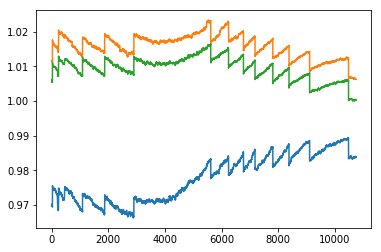

In [7]:
plt.plot(log_dict['s701a']['voltage'])
plt.plot(log_dict['s701b']['voltage'])
plt.plot(log_dict['s701c']['voltage'])

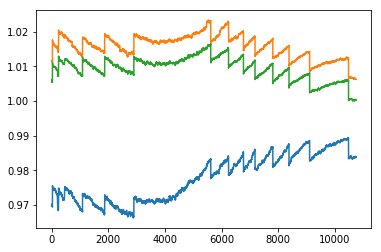

In [9]:
plt.plot(log_dict['s701a']['voltage'])
plt.plot(log_dict['s701b']['voltage'])
plt.plot(log_dict['s701c']['voltage'])

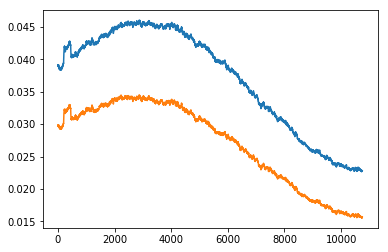

In [8]:
plt.plot(log_dict['u_metrics']['u_worst'])
plt.plot(log_dict['u_metrics']['u_mean'])

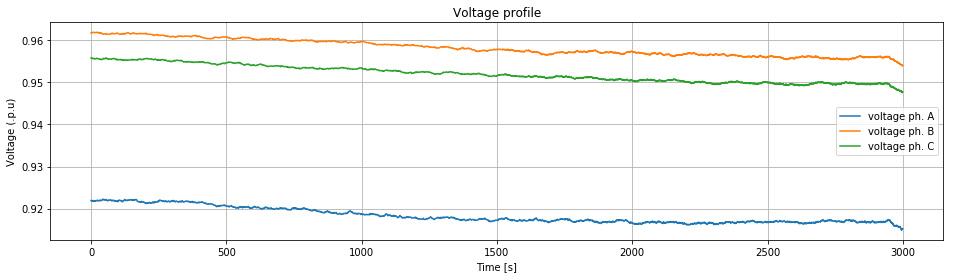

In [20]:
fig1 = plt.figure(figsize = [16, 4])
plt.plot(log_dict['s701a']['voltage'][1000:4000], label='voltage ph. A')
plt.plot(log_dict['s701b']['voltage'][1000:4000], label='voltage ph. B')
plt.plot(log_dict['s701c']['voltage'][1000:4000], label='voltage ph. C')
plt.grid()
plt.title('Voltage profile')
plt.xlabel('Time [s]')
plt.ylabel('Voltage (.p.u)')
plt.legend()

In [9]:
sim_params 

{'M': 2.0,
 'N': 0.1,
 'P': 4.0,
 'Q': 0.5,
 'T': 100,
 'Z': 100,
 'is_disable_log': False,
 'is_disable_y': False,
 'vectorized_mode': True,
 'hack_setting': {'default_control_setting': [1.039,
   1.04,
   1.04,
   1.041,
   1.042]},
 'env_config': {'clip_actions': True, 'sims_per_step': 30},
 'simulation_config': {'network_model_directory': '/home/toanngo/Documents/GitHub/cigar-document/ceds-cigar/pycigar/data/ieee37busdata_regulator_attack/ieee37.dss',
  'custom_configs': {'solution_mode': 1,
   'solution_number': 1,
   'solution_step_size': 1,
   'solution_control_mode': -1,
   'solution_max_control_iterations': 1000000,
   'solution_max_iterations': 30000,
   'power_factor': 0.9}},
 'scenario_config': {'multi_config': False,
  'start_end_time': [3601, 14400],
  'network_data_directory': '/home/toanngo/Documents/GitHub/ceds-cigar/pycigar/data/ieee37busdata_battery/load_solar_data.csv',
  'custom_configs': {'load_scaling_factor': 1.0,
   'solar_scaling_factor': 0.05,
   'slack_bus_v

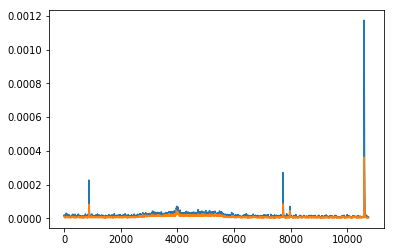

In [17]:
plt.plot(log_dict['y_metrics']['y_worst'])
plt.plot(log_dict['y_metrics']['y_mean'])

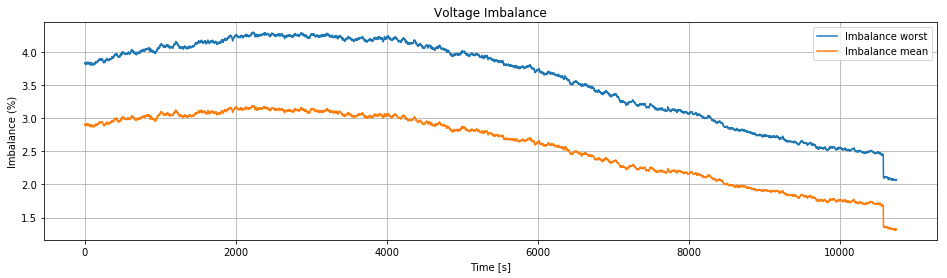

In [7]:
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.array(log_dict['u_metrics']['u_worst'])*100, label='Imbalance worst')
plt.plot(np.array(log_dict['u_metrics']['u_mean'])*100, label='Imbalance mean')
plt.grid()
plt.title('Voltage Imbalance')
plt.xlabel('Time [s]')
plt.ylabel('Imbalance (%)')
plt.legend()

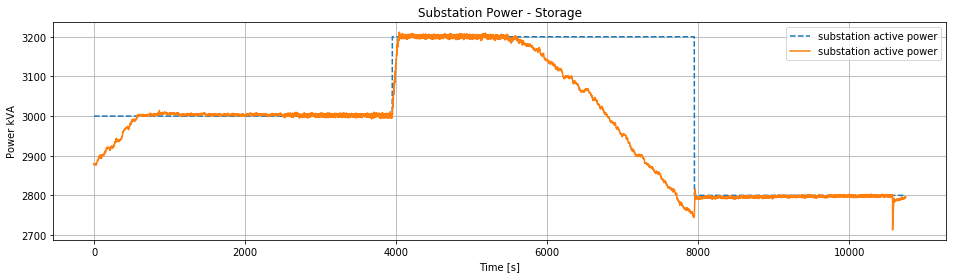

In [8]:
fig1 = plt.figure(figsize = [16, 4])
plt.plot(np.asarray(log_dict['psc_cent_701']['p_target']),'--',label="substation active power")
plt.plot(np.asarray(log_dict['network']['substation_power'])[:,0],label="substation active power")
plt.grid()
plt.title('Substation Power - Storage')
plt.xlabel('Time [s]')
plt.ylabel('Power kVA')
plt.legend()

In [10]:
solar_load.columns

Index(['S701a', 'S701b', 'S701c', 'S712c', 'S713c', 'S714a', 'S714b', 'S718a',
       'S720c', 'S722b', 'S722c', 'S724b', 'S725b', 'S727c', 'S728', 'S729a',
       'S730c', 'S731b', 'S732c', 'S733a', 'S734c', 'S735c', 'S736b', 'S737a',
       'S738a', 'S740c', 'S741c', 'S742a', 'S742b', 'S744a', 'S701a_pv',
       'S701b_pv', 'S701c_pv', 'S712c_pv', 'S713c_pv', 'S714a_pv', 'S714b_pv',
       'S718a_pv', 'S720c_pv', 'S722b_pv', 'S722c_pv', 'S724b_pv', 'S725b_pv',
       'S727c_pv', 'S728_pv', 'S729a_pv', 'S730c_pv', 'S731b_pv', 'S732c_pv',
       'S733a_pv', 'S734c_pv', 'S735c_pv', 'S736b_pv', 'S737a_pv', 'S738a_pv',
       'S740c_pv', 'S741c_pv', 'S742a_pv', 'S742b_pv', 'S744a_pv'],
      dtype='object')

/home/toanngo/anaconda3/envs/pycigar/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/toanngo/anaconda3/envs/pycigar/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


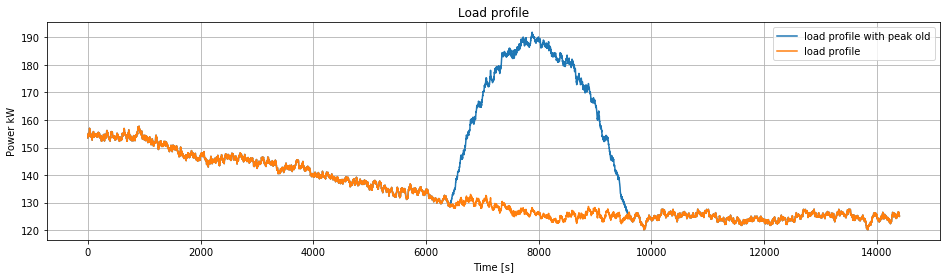

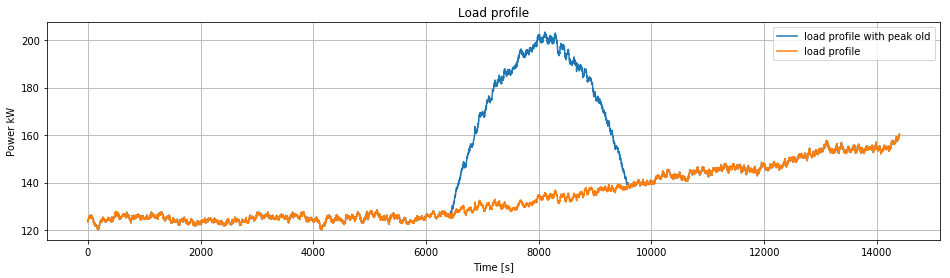

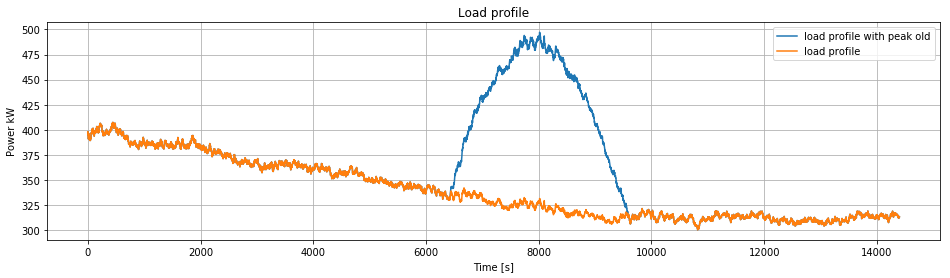

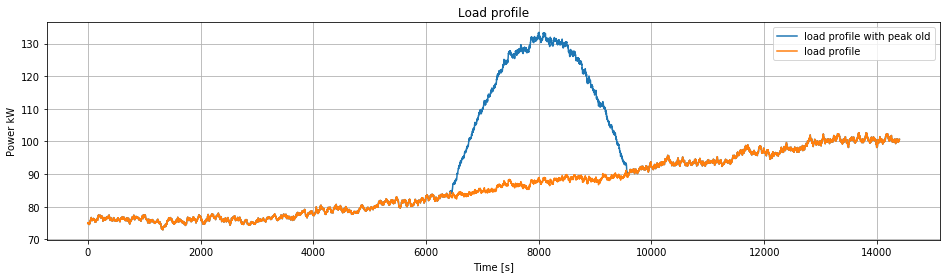

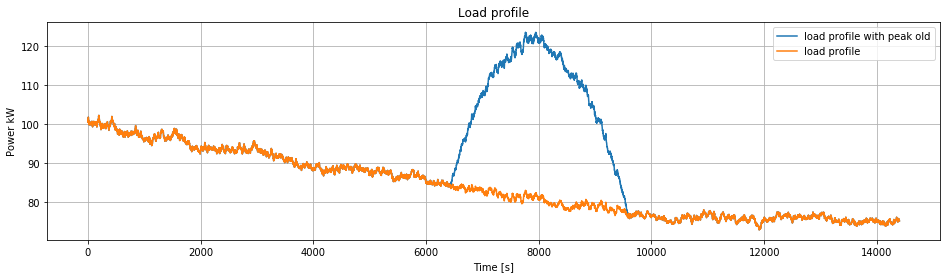

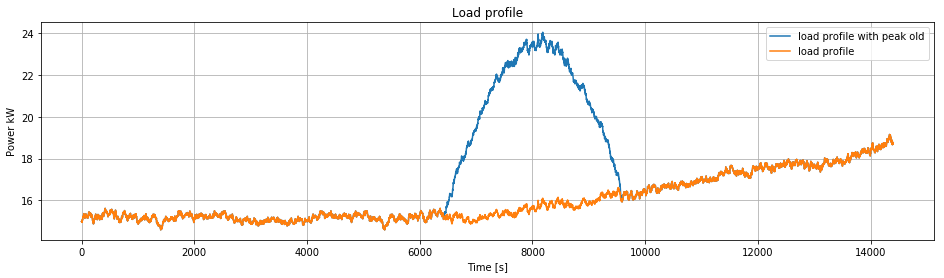

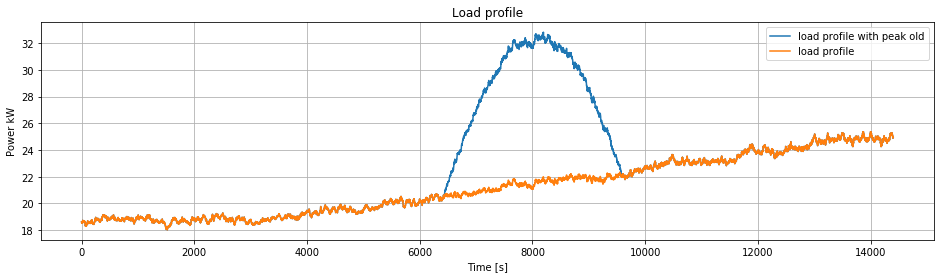

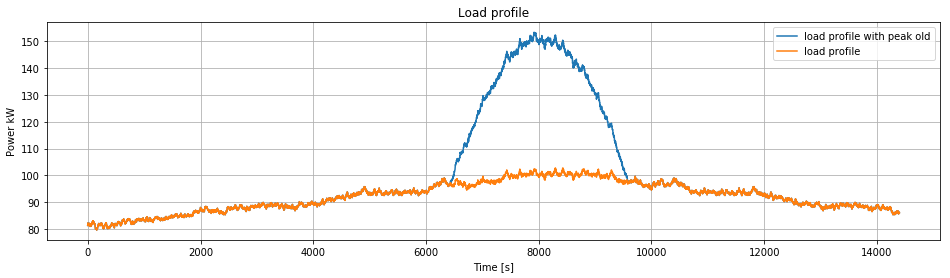

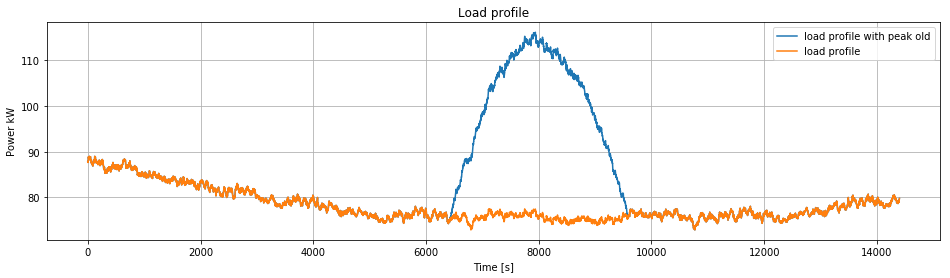

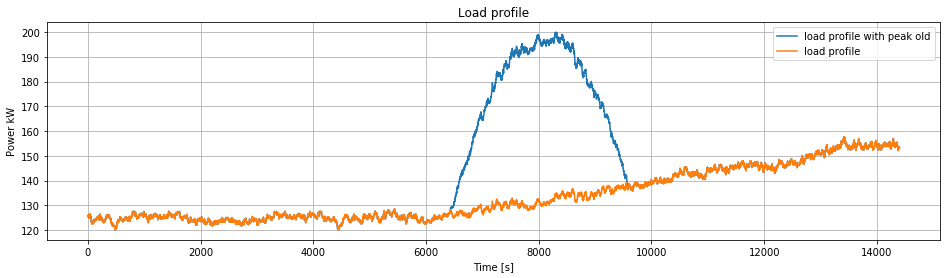

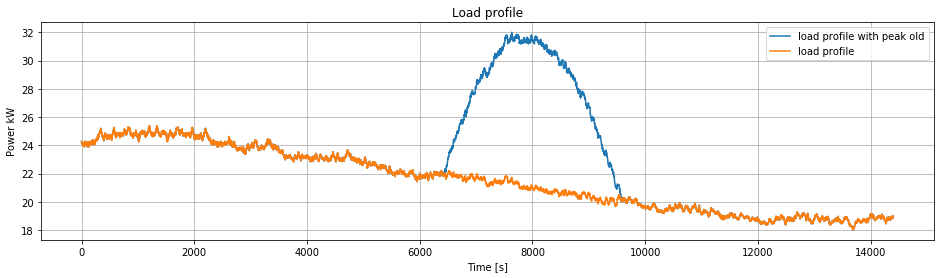

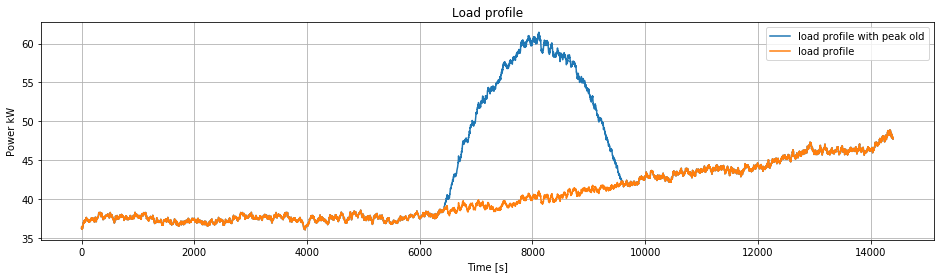

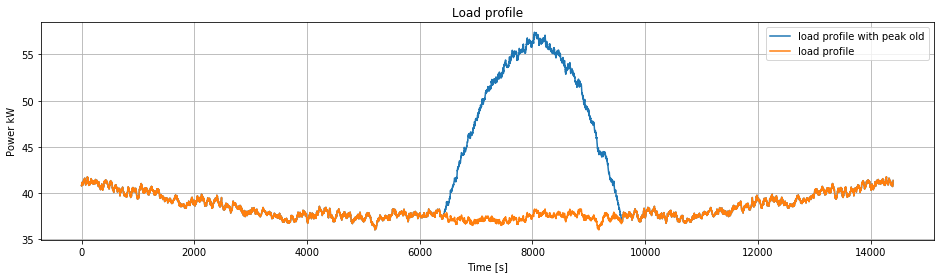

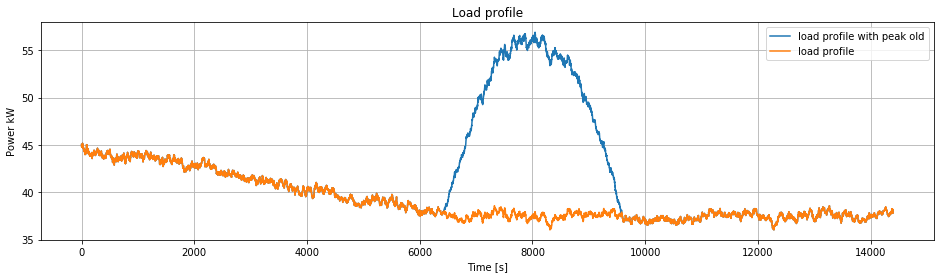

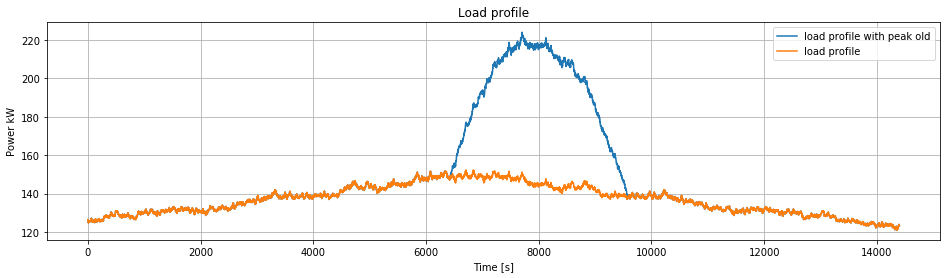

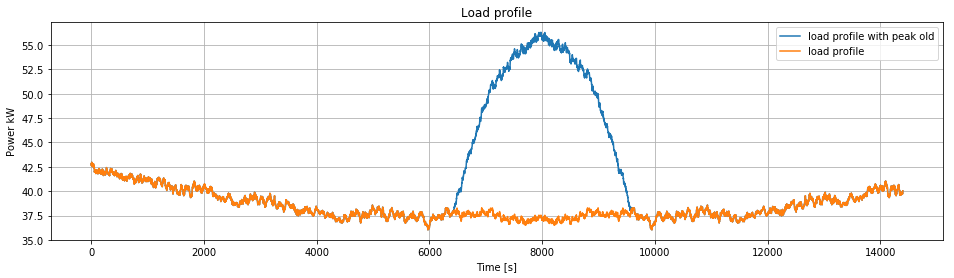

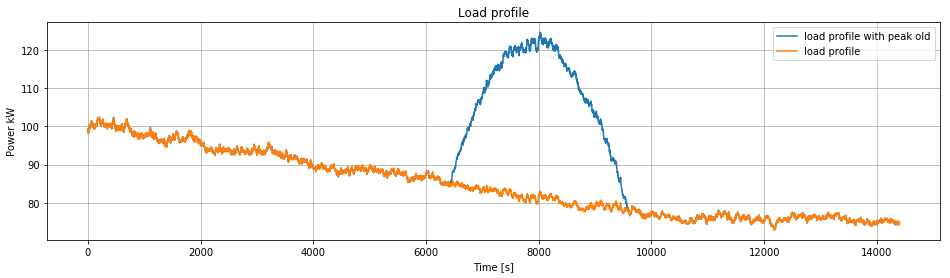

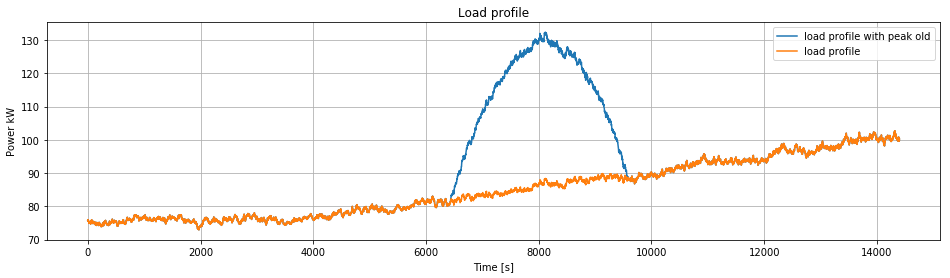

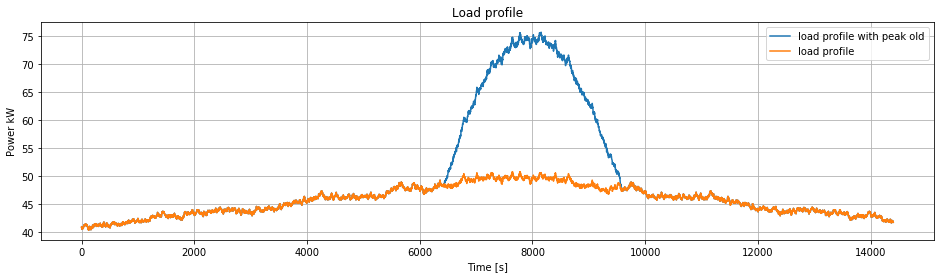

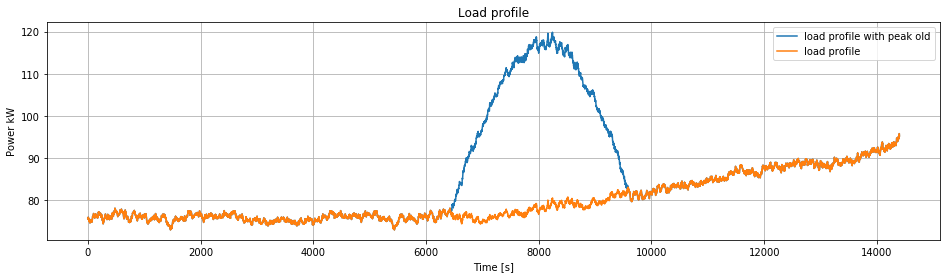

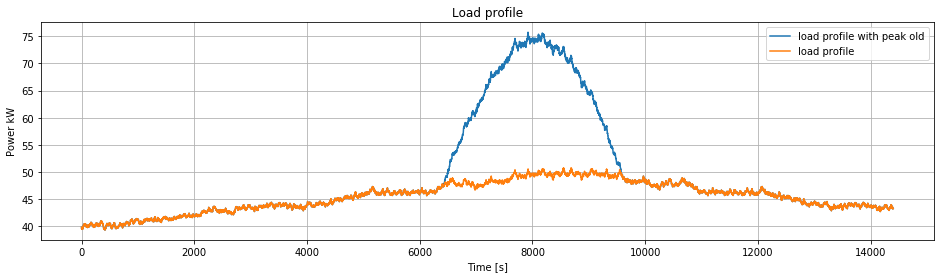

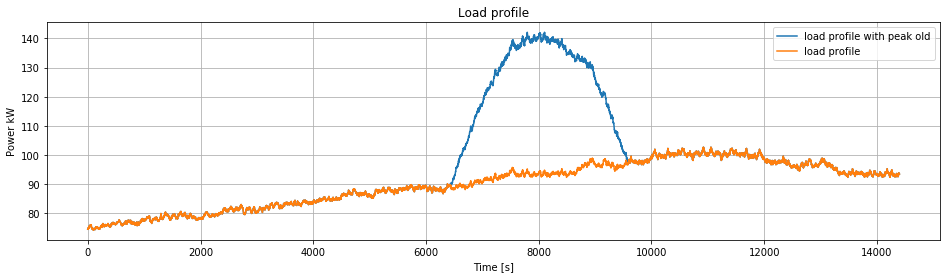

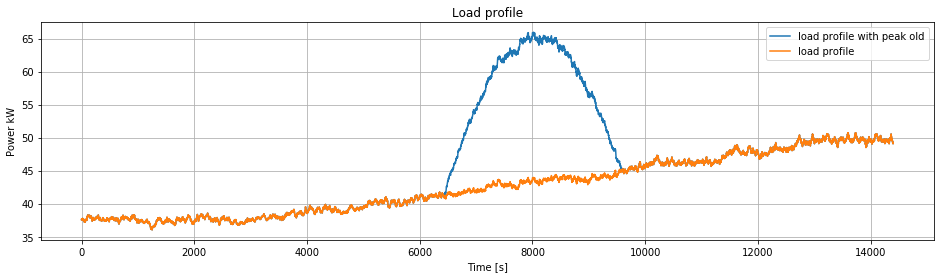

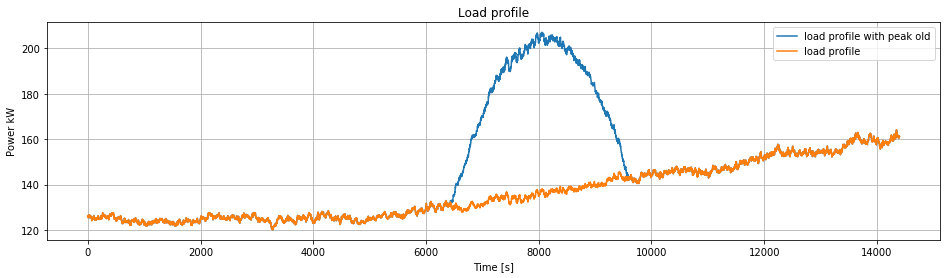

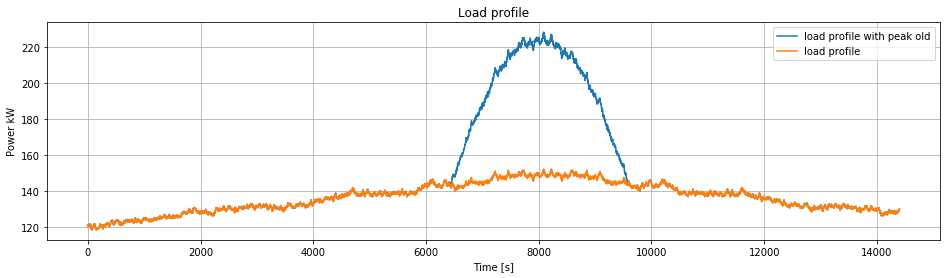

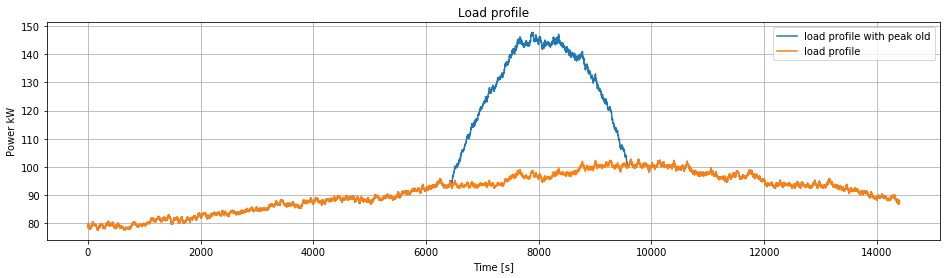

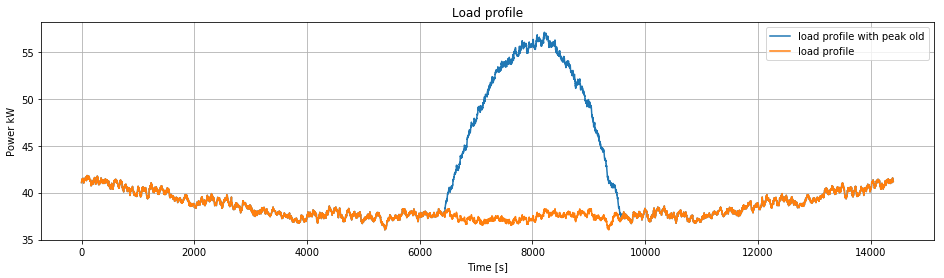

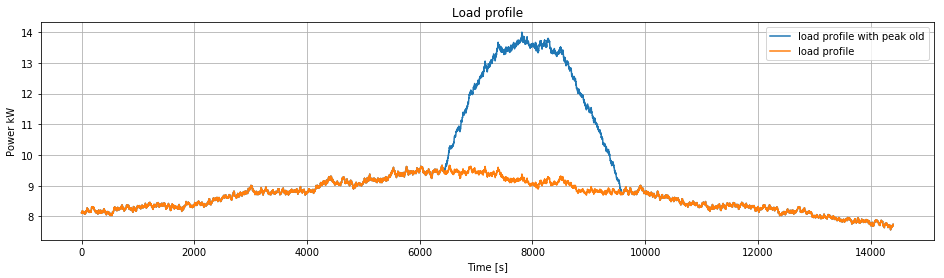

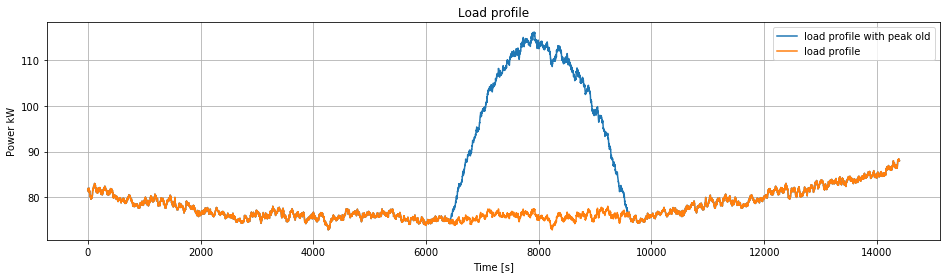

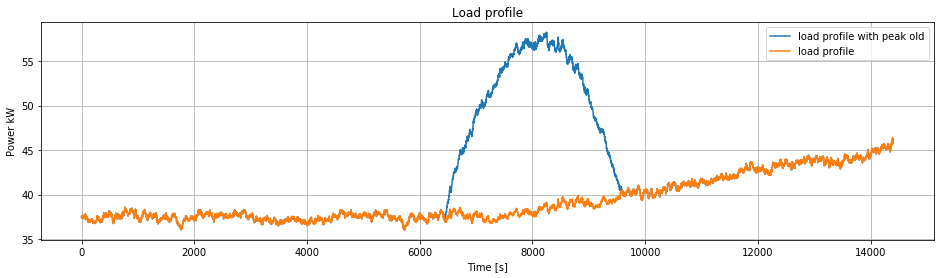

In [5]:
import matplotlib.pyplot as plt

solar_load_new = solar_load.copy()
for load in solar_load.columns[:int(len(solar_load.columns)/2)]:
    fig1 = plt.figure(figsize = [16, 4])
    x = np.array(range(-2000, 2000))
    y = (-0.2*x**2 +3*x)/1000000 + 0.5 #+ np.random.normal(10, 0.5, x.shape[0])
    new_load = np.zeros(solar_load[load].shape[0])
    new_load[6000:10000] = y
    new_load = np.multiply(new_load, new_load > 0) 
    solar_load_new_value = np.multiply(new_load*solar_load[load], new_load <= solar_load[load])  + \
                     np.multiply(solar_load[load], new_load <= solar_load[load])
    
    solar_load_new[load] = solar_load_new_value
    #plt.plot(solar_load_new_value,label="load profile with peak " + load)
    plt.plot(np.asarray(solar_load_bat[load]),label="load profile with peak old")
    plt.plot(np.asarray(solar_load[load]),label="load profile")
    # plt.plot(-np.asarray(Logger.log_dict['network']['substation_power'])[:,1],label="substation reactive power")
    # plt.plot((np.asarray(Logger.log_dict['network']['substation_power'])[:,0]**2 + np.asarray(Logger.log_dict['network']['substation_power'])[:,1]**2)**0.5,label="substation apparent power")
    plt.grid()
    plt.title('Load profile')
    plt.xlabel('Time [s]')
    plt.ylabel('Power kW')
    plt.legend()
    plt.show()

In [9]:
solar_load_new.to_csv('./load_solar_data_new.csv', index=False)

In [8]:
solar_load_new

,S701a,S701b,S701c,S712c,S713c,S714a,S714b,S718a,S720c,S722b,...,S734c_pv,S735c_pv,S736b_pv,S737a_pv,S738a_pv,S740c_pv,S741c_pv,S742a_pv,S742b_pv,S744a_pv
0,153.498095,123.820921,397.393281,74.998196,101.058024,14.982539,18.608182,81.298122,87.787974,125.625576,...,34.682480,72.981613,34.650818,106.209634,103.220487,72.655319,29.456819,6.448277,58.550762,30.545572
1,153.888862,123.437081,398.155538,75.129048,100.717811,14.985800,18.571140,81.312794,87.672246,125.858922,...,34.761531,73.003157,34.600662,106.279287,103.250435,72.652675,29.434301,6.454909,58.564721,30.565936
2,154.296907,123.628316,397.345749,75.112356,100.755853,14.967991,18.565200,82.149289,87.660056,125.747546,...,34.847485,72.918207,34.569914,106.179119,103.385986,72.667941,29.411082,6.461086,58.661187,30.579120
3,154.583609,123.880350,396.446687,75.055569,100.504302,14.987306,18.558114,81.792515,87.911947,125.537857,...,34.887707,72.892787,34.584977,106.260821,103.392357,72.672617,29.398747,6.472421,58.706494,30.582643
4,154.517872,123.923076,395.427583,74.826989,100.676553,15.001729,18.532058,81.905336,87.829146,125.385193,...,34.926359,72.958361,34.619464,106.599821,103.364143,72.747136,29.372332,6.475503,58.768830,30.589603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,125.540607,159.842405,312.939251,100.556106,75.341281,18.771625,24.967559,86.107378,79.472439,153.604157,...,45.840271,98.232810,42.953389,145.072678,140.561433,90.551434,38.270336,8.243912,74.917280,39.341722
14396,125.216126,159.906007,313.029138,100.576919,75.459595,18.718710,24.988353,86.230690,79.498935,153.589575,...,45.900495,98.142880,42.939185,145.059565,140.626064,90.498970,38.280046,8.243502,74.999962,39.382593
14397,124.977787,160.244207,313.226022,100.416297,75.399640,18.722321,24.969887,86.242375,79.658509,153.592659,...,45.915999,98.094995,42.912312,144.955442,140.649219,90.493950,38.280645,8.247639,75.050040,39.386031
14398,124.940089,160.203535,313.548161,100.512246,75.364451,18.703354,24.908765,86.182041,79.547424,153.526153,...,45.887299,98.139912,42.932708,144.868429,140.677967,90.471214,38.250171,8.247992,75.061065,39.371652
